# 1. Tennis Surface Check

Use a linear regression and statsmodels to find which surface type predicts the most points for Federer in the `tennis.csv` dataset.

1. Give a one-paragraph interpretation of the coefficients, and the meaning of the p-value. 

2. Answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

3. Do a t-test to find that the largest coefficient is statistically significantly different from the second largest (hint: you can run a t-test only with mean values and standard deviations)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set()

In [2]:
tennis = pd.read_csv('data/tennis.csv')

surface = tennis.loc[:,['surface','player1 total points won']]
surface = surface.dropna()
pd.get_dummies(surface['surface'],drop_first=False).columns

Index(['Indoor: Carpet', 'Indoor: Hard', 'Outdoor: Clay', 'Outdoor: Grass',
       'Outdoor: Hard'],
      dtype='object')

In [3]:
pd.get_dummies(surface['surface'],drop_first=False).sum()

Indoor: Carpet     57
Indoor: Hard      194
Outdoor: Clay     216
Outdoor: Grass    132
Outdoor: Hard     428
dtype: int64

In [4]:
model = sm.OLS(
    surface['player1 total points won'],
    sm.add_constant(
        pd.get_dummies(surface['surface'],drop_first=True)
    )
).fit()

print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     player1 total points won   R-squared:                       0.046
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     12.38
Date:                      Sun, 24 Jan 2021   Prob (F-statistic):           7.81e-10
Time:                              19:14:54   Log-Likelihood:                -4849.5
No. Observations:                      1027   AIC:                             9709.
Df Residuals:                          1022   BIC:                             9734.
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

**1. Give a one-paragraph interpretation of the coefficients, and the meaning of the p-value.** 
    
    Federer performs best on surface 'Outdoor: Grass'. Based on the coefficients we can say that he scores 15 times as many
    points on 'Outdoor: Grass' as he does on 'Indoor: Carpet'. He is nearly 6 times less likely to score points 'Indoor: Hard' relative to 'Indoor: Carpet'.
        Indoor: Hard      -6.1456
        Outdoor: Clay      4.8599
        Outdoor: Grass    14.9386
        Outdoor: Hard      4.4635
    Based on the p-values, surface is not statiscally signficant in predicting Federer's scored points, with the exception of 'Outdoor: Grass', as expected.
    Given that the coefficient indicates a factor of 15x over 'Indoor: Carpet', nearly 3x over Outdoor: Hard and 'Outdoor: Clay' and is inversely related to 'Indoor: Hard' 
    by nearly 2.5x this surface type is specifically, statistically significant.

**2. Answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?**

    Yes a constant is required. As otherwise the coefficients would in fact be the means of each surface type and does not describe any relative behaviours. Including a 
    constant highlights that the surface is not statiscally signficant in predicting Federer's scored points, with the exception of 'Outdoor: Grass', as expected.

**3. Do a t-test to find that the largest coefficient is statistically significantly different from the second largest (hint: you can run a t-test only with mean values and standard deviations)**

In [5]:
from scipy.stats import ttest_ind

a = surface[surface['surface']=='Outdoor: Grass']
a = a.iloc[:,1]
b = surface[surface['surface']=='Outdoor: Clay']
b = b.iloc[:,1]

ttest_ind(a, b)

Ttest_indResult(statistic=2.881235650452015, pvalue=0.0042083109878672375)

In [6]:
import statistics
from scipy.stats import ttest_ind_from_stats

ttest_ind_from_stats(mean1=a.mean(), std1=np.sqrt(statistics.variance(a)), nobs1=132,
                     mean2=b.mean(), std2=np.sqrt(statistics.variance(b)), nobs2=216)

Ttest_indResult(statistic=2.881235650452015, pvalue=0.0042083109878672375)

# 2. Titanic prediction contest

Use whatever tricks you can to best model whether a passenger would survive the titanic disaster (using linear regression).

1. Use non-regularized regression to build the best model you can. Show 2 alternate model speficications and explain why you chose the one you did

2. Interpret the coefficients in your model. Which attributes best relate to survival probability? How does this relate to socio-economic characteristics and "real-world" interpretation?

3. Use regularized regression to build a purely predictive model. Can you improve your accuracy? Plot the regularized model against the interpretable model predictions in a regression plot to make your case.

In [162]:
titanic = sns.load_dataset('titanic')
# print(titanic.info())
# print(titanic.isnull().sum())
titanic.describe(include='all')
df = titanic.drop('deck',axis=1) # drop deck as it has significant amount of missing data 688 NaN/891
df = df.dropna()
df['adult_male'] = pd.get_dummies(df['adult_male'], drop_first=False)
# df['alone'] = pd.get_dummies(df['alone'], drop_first=False)
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,0,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,1,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,1,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,1,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,0,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q,Third,woman,1,Queenstown,no,False
886,0,2,male,27.0,0,0,13.0000,S,Second,man,0,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,1,Southampton,yes,True
889,1,1,male,26.0,0,0,30.0000,C,First,man,0,Cherbourg,yes,True


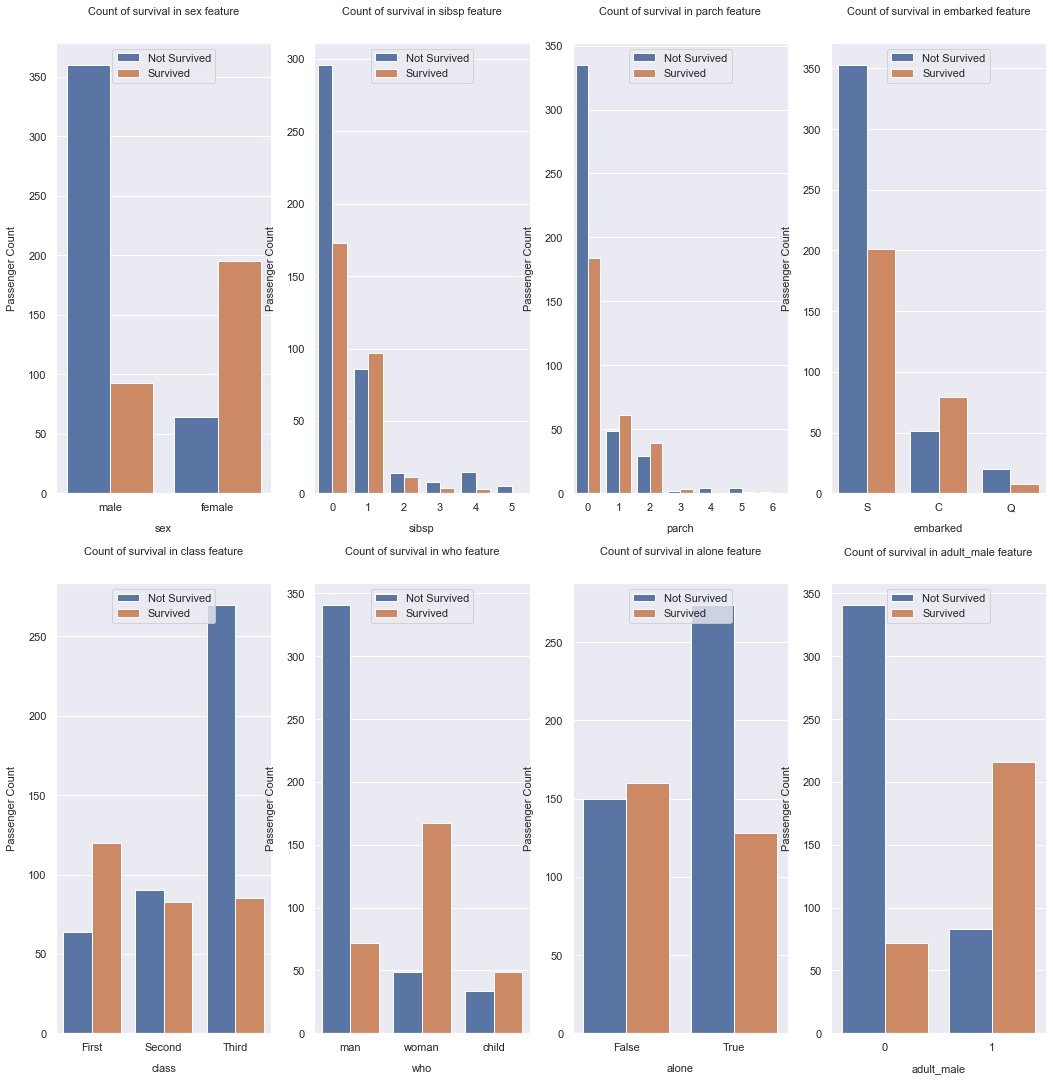

In [182]:
# ref : https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial
cat_features = ['sex','sibsp','parch','embarked','class','who','alone','adult_male']

fig, axs = plt.subplots(figsize=(10, 10))
plt.subplots_adjust(right=1.5, top=1.5)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 4, i)
    sns.countplot(x=feature, hue='survived', data=df)
    
    plt.xlabel('{}'.format(feature), size=11, labelpad=11)
    plt.ylabel('Passenger Count', size=11, labelpad=11)    
    plt.tick_params(axis='x', labelsize=11)
    plt.tick_params(axis='y', labelsize=11)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 11})
    plt.title('Count of survival in {} feature'.format(feature), size=11, y=1.05)

plt.show()

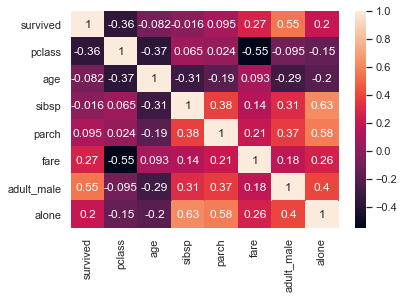

In [124]:
sns.heatmap(data=df.corr(), annot=True)

In [179]:
# If we're predicting an outcome which is a boolean, then the outuput of our model is the percentage probability that y=1

print(sm.OLS(
    (df['survived']),
    sm.add_constant(
        df[['age']].join(
            [(pd.get_dummies(df['sex'], drop_first=True)),
             (pd.get_dummies(df['embark_town'], drop_first=True)),
             (pd.get_dummies(df['class'], drop_first=True)),
             (pd.get_dummies(df['who'], drop_first=True))])
        )
    ).fit(cov_type='HC2').summary())

                            OLS Regression Results                            
Dep. Variable:               survived   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     106.1
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          1.72e-115
Time:                        20:30:09   Log-Likelihood:                -314.03
No. Observations:                 712   AIC:                             646.1
Df Residuals:                     703   BIC:                             687.2
Df Model:                           8                                         
Covariance Type:                  HC2                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0264      0.080     12.815      

In [180]:
print(sm.OLS(
    (df['survived']),
    sm.add_constant(
        df[['age']].join(
            [(pd.get_dummies(df['sex'], drop_first=True)),
             (pd.get_dummies(df['embark_town'], drop_first=True)),
             (pd.get_dummies(df['class'], drop_first=True))])
        )
    ).fit(cov_type='HC2').summary())

                            OLS Regression Results                            
Dep. Variable:               survived   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     122.3
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          1.02e-105
Time:                        20:30:39   Log-Likelihood:                -326.49
No. Observations:                 712   AIC:                             667.0
Df Residuals:                     705   BIC:                             699.0
Df Model:                           6                                         
Covariance Type:                  HC2                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1643      0.052     22.431      

In [181]:
print(sm.OLS(
    (df['survived']),
    sm.add_constant(
        df[['age']].join(
            [(pd.get_dummies(df['sex'], drop_first=True)),
             (pd.get_dummies(df['class'], drop_first=True))])
        )
    ).fit(cov_type='HC2').summary())

                            OLS Regression Results                            
Dep. Variable:               survived   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     174.0
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          1.05e-103
Time:                        20:30:56   Log-Likelihood:                -328.74
No. Observations:                 712   AIC:                             667.5
Df Residuals:                     707   BIC:                             690.3
Df Model:                           4                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1245      0.049     22.851      0.0

In [ ]:
print(df['sex'].unique())
print(df['embark_town'].unique())
print(df['class'].unique())
print(df['who'].unique())
print(df['alone'].unique())

**1. Use non-regularized regression to build the best model you can. Show 2 alternate model speficications and explain why you chose the one you did**

    A study of some of the variables with respect to survival helps to understand and discern which variables may add value to the model.

    The model that retained all the initial variable had a better R2 outcome but noted some poor statistical significance of the embarked town and alone variable.
    These were removed to improve the statistical significance.

**2. Interpret the coefficients in your model. Which attributes best relate to survival probability? How does this relate to socio-economic characteristics and "real-world" interpretation?**

    Age, sex and class best relate to the survival probability. This is in line with what we can expect based on socio-economic characteristics : although there were far more men aboard, children and woman were prioritized. It also can be seen that those who were aboard in a higher class had a greater likelihood of survival with the disparity between the classes increasingly quite sharply.

**3. Use regularized regression to build a purely predictive model. Can you improve your accuracy? Plot the regularized model against the interpretable model predictions in a regression plot to make your case.**

In [240]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# x = df['age']
# y = df['survived']
# X = PolynomialFeatures(15).fit_transform(x[:, np.newaxis], y)
# est = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha=0.2, L1_wt=1.0)

In [242]:
# plt.scatter(x, y)
# model.fit(x[:, np.newaxis], y)
# xfit = np.random.randint(df['age'].max(), size=1000)
# plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

# 3. House Price prediction

Using the techniques you learned, use everything you can to build the best **interpretable** (eg. non-regularized) regression model on the `house_price.csv` dataset. You also have `house_price_data_description.txt` to help -- full description of each column.

Here's a brief version of what you'll find in the data description file.

**SalePrice** - the property's sale price in dollars. **This is the target variable that you're trying to predict.**


In [351]:
house = pd.read_csv('data/house_price.csv')
clean = house.isnull().sum().sort_values(ascending=False)
clean[clean > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [352]:
df = house.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage'],axis=1)
df = df.dropna()

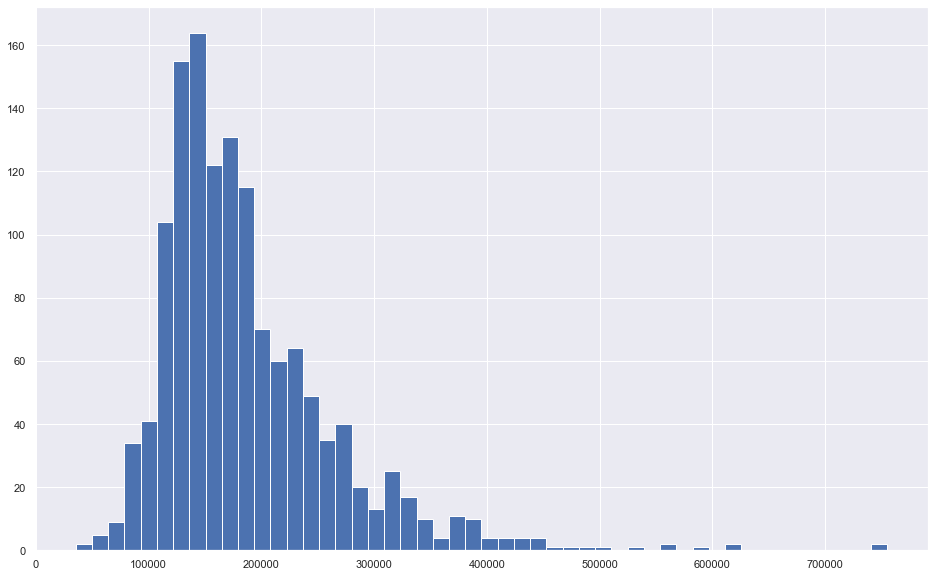

In [353]:
fig, ax = plt.subplots(figsize = (16, 10))
df['SalePrice'].hist(bins=50)

In [354]:
correlation_matrix = df.corr()
(correlation_matrix[correlation_matrix['SalePrice'].abs() > 0.5]['SalePrice']).sort_values(ascending=False)

# top correlated features

SalePrice       1.000000
OverallQual     0.783546
GrLivArea       0.711706
GarageCars      0.640154
GarageArea      0.607535
1stFlrSF        0.604714
TotalBsmtSF     0.602042
FullBath        0.569313
TotRmsAbvGrd    0.551821
YearBuilt       0.504297
YearRemodAdd    0.501435
Name: SalePrice, dtype: float64

In [355]:
# fig, ax = plt.subplots(figsize = (16, 10))
# sns.scatterplot(data=df, x="GrLivArea", y="SalePrice")

In [356]:
# fig, ax = plt.subplots(figsize = (16, 10))
# sns.scatterplot(data=df, x="GarageCars", y="SalePrice")

In [357]:
# fig, ax = plt.subplots(figsize = (16, 10))
# sns.scatterplot(data=df, x="TotalBsmtSF", y="SalePrice")

In [361]:
y = df['SalePrice']
x_matrix = ['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd']
dff = df[x_matrix]

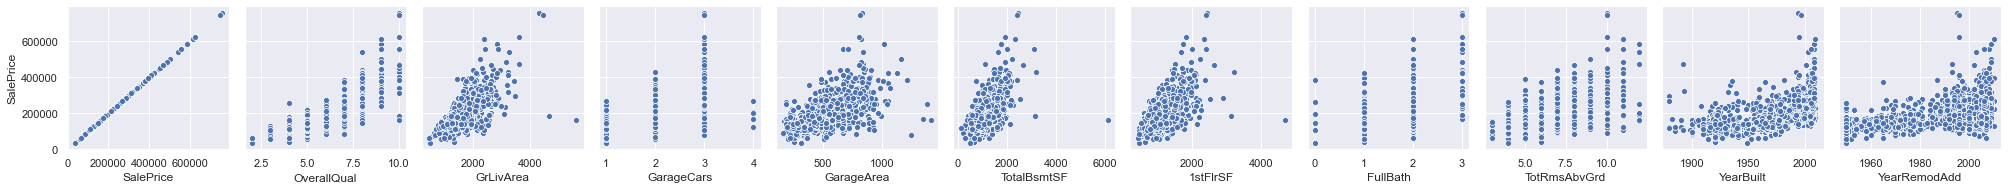

In [360]:
sns.pairplot(data=dff, y_vars=['SalePrice'], x_vars=dff.columns)

In [369]:
x = dff.drop('SalePrice',axis=1)
x = sm.add_constant(x)

y = (dff['SalePrice'])/100000

model = sm.OLS(y,x)
results = model.fit(cov_type='HC2')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     211.1
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          5.63e-266
Time:                        22:38:03   Log-Likelihood:                -609.97
No. Observations:                1338   AIC:                             1242.
Df Residuals:                    1327   BIC:                             1299.
Df Model:                          10                                         
Covariance Type:                  HC2                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -11.9085      1.476     -8.068   

In [373]:
x = dff[['OverallQual','GrLivArea','GarageCars','FullBath','YearBuilt','YearRemodAdd']]
x = sm.add_constant(x)

y = (dff['SalePrice'])/100000

model = sm.OLS(y,x)
results = model.fit(cov_type='HC2')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     297.0
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          1.98e-241
Time:                        22:39:05   Log-Likelihood:                -661.43
No. Observations:                1338   AIC:                             1337.
Df Residuals:                    1331   BIC:                             1373.
Df Model:                           6                                         
Covariance Type:                  HC2                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -12.3035      1.769     -6.956   